# Оценка повышения уровня благополучия детей по всему миру

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше столбцов

In [3]:
df = pd.read_csv('./stud_math.csv')

In [4]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [5]:
df.shape

(395, 30)

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   pstatus              350 non-null    object 
 6   medu                 392 non-null    float64
 7   fedu                 371 non-null    float64
 8   mjob                 376 non-null    object 
 9   fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [8]:
# Сколько нулевых значений
df.isna().sum()

school                  0
sex                     0
age                     0
address                17
famsize                27
pstatus                45
medu                    3
fedu                   24
mjob                   19
fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

# Первые мысли о дата фрейме:

1. Присутствуют нулевые значения в большинстве колонок, но их не так много.
2. Данные хорошо сгруппированы, вполне информативные

# Вспомогательные функции:

In [9]:
def get_statistical_borders(column):
    perc25 = df[column].quantile(q=0.25)
    perc75 = df[column].quantile(q=0.75)
    IQR = perc75 - perc25
    
    take_from = perc25 - 1.5*IQR
    take_to = perc75 + 1.5*IQR

    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75), 
        'IQR: {}, '.format(IQR),
        'Границы выбросов: [{f}, {l}].'.format(f=take_from, l=take_to)
    )
    
    return take_from, take_to


def filter_statistical_outliers(column, group_size):
    return df[
        df[column].isin(
            df[column].value_counts()[
                df[column].value_counts() >= group_size
            ].index
        )
    ]


def show_grouped_info(column):
    display(pd.DataFrame(df[column].value_counts()))
    df.loc[:, [column]].info()


def change_column_type_and_populate_none(column, new_type, value_for_none):
    if value_for_none is not None:
        df.loc[df[column].isna(), column] = value_for_none
    df[column] = df[column].astype(new_type)

# 1. Провести первичную обработку данных.

Просмотр колонок по отдельности и приведение данных каждой колонки в удобное для анализа состояние:

## school

In [10]:
show_grouped_info('school')

,school
GP,349
MS,46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Данные чистые, нет пустых значений. Данные только по двум школам или по двум сетям школ.

## sex

In [11]:
show_grouped_info('sex')

,sex
F,208
M,187


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Данные чистые, нет пустых значений. Приблизительно одинаковое количество обоих полов.

## age

In [12]:
show_grouped_info('age')

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     395 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


Данные чистые, нет пустых значений. В сгруппированном виде видно что количество данных в возрастной категории [20, 21, 22] очень низкое. Возможно будет целесообразно исключить возрастные категории [20, 21, 22]. В колонке только числа, приведем тип колонки к Int32

In [13]:
df['age'] = df['age'].astype('Int32')

## address

In [14]:
show_grouped_info('address')

,address
U,295
R,83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Есть нулевые значения (17 штук). Количество учащихся в городе приобладает. Так как учащихся в городе в 3.5 раза больше, можно заполнить пропущенные поля в этом же соотношении.

In [15]:
indexes_for_U = df[df['address'].isna()]['address'].head(13).index

# городские учащиеся
df.loc[indexes_for_U, 'address'] = 'U'

# учащиеся за городом
df.loc[df[df['address'].isna()]['address'].index, 'address'] = 'R'

## famsize

In [16]:
show_grouped_info('famsize')

,famsize
GT3,261
LE3,107


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Колонка famsize содержит 27 нулевых значений. Попробуем заполнить пропуски в соотношении 1 к 2.5 для GT3 и LE3.

In [17]:
indexes_for_GT3 = df[df['famsize'].isna()]['famsize'].head(20).index

# GT3
df.loc[indexes_for_GT3, 'famsize'] = 'GT3'

# LE3
df.loc[df[df['famsize'].isna()]['famsize'].index, 'famsize'] = 'LE3'

## Medu

In [18]:
show_grouped_info('medu')

,medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   medu    392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


В столбце только цифры, логичнее его будет заменить на Int32. Три значения пропущено, скорее всего у этих людей нет никакого образования.

In [19]:
change_column_type_and_populate_none('medu', 'Int32', 0)

## Fedu

In [20]:
show_grouped_info('fedu')

,fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    371 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


В столбце только цифры, логичнее его будет заменить на Int32. Так-же 23 значения пропущено, скорее всего у этих людей нет никакого образования. Есть одно аномальное значение равное 40. Предположительно это ошибка и человек хотел написать 4, заменим 40 на 4.

In [21]:
df.loc[df['fedu'] == 40, 'fedu'] = 4

In [22]:
change_column_type_and_populate_none('fedu', 'Int32', 0)

## Mjob

In [23]:
show_grouped_info('mjob')

,mjob
other,133
services,98
at_home,58
teacher,55
health,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    376 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В колонке 18 пропущенных значений, предположительно человек не работает. Установим значение **at_home** для пустых значений.

In [24]:
df.loc[df['mjob'].isna(), 'mjob'] = 'at_home'

## Fjob

In [25]:
show_grouped_info('fjob')

,fjob
other,197
services,102
teacher,29
at_home,16
health,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fjob    359 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В колонке 36 пропущенных значений, предположительно человек не работает. Установим значение at_home для пустых значений.

In [26]:
df.loc[df['fjob'].isna(), 'fjob'] = 'at_home'

## reason

In [27]:
show_grouped_info('reason')

,reason
course,137
home,104
reputation,103
other,34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В колонке 17 пропущенных значений, поставим значение **other**.

In [28]:
df.loc[df['reason'].isna(), 'reason'] = 'other'

## guardian

In [29]:
show_grouped_info('guardian')

,guardian
mother,250
father,86
other,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В столбце 29 пропущенных значений. Если опекун не установлен, то возможно ребенок на попечении дестких домов или других слежб помощи. Отнесем этих детей к группе **other**.

In [30]:
df.loc[df['guardian'].isna(), 'guardian'] = 'other'

## traveltime

In [31]:
show_grouped_info('traveltime')

,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  367 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


В столбце 26 постых значений. Установим у них среднее значение. В столбце только целые числа, приведем тип столбца в Int32.

In [32]:
traveltime_mean = df[~df['traveltime'].isna()]['traveltime'].apply(lambda x: int(x)).mean()
traveltime_mean = round(traveltime_mean, 0)
change_column_type_and_populate_none('traveltime', 'Int32', traveltime_mean)

## studytime

In [33]:
show_grouped_info('studytime')

,studytime
2.0,194
1.0,103
3.0,64
4.0,27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  388 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Содержит 7 нулевых значений. Возможно ребенок не учиться в свободное от школы время либо проводит очень мало времени за учебой, отнесем его к группе 1. В столбце только целые числа, приведем тип столбца в Int32.

In [34]:
change_column_type_and_populate_none('studytime', 'Int32', 1)

## failures

In [35]:
show_grouped_info('failures')

,failures
0.0,293
1.0,49
2.0,16
3.0,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  373 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Пустых 19 значений, приведем к 0, это более вероятно. Приведем поле к Int32, так как колонка числовая.

In [36]:
change_column_type_and_populate_none('failures', 'Int32', 0)

## schoolsup

In [37]:
show_grouped_info('schoolsup')

,schoolsup
no,335
yes,51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  386 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [38]:
df.loc[df['schoolsup'].isna(), 'schoolsup'] = 'no'

## famsup

In [39]:
show_grouped_info('famsup')

,famsup
yes,219
no,137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [40]:
df.loc[df['famsup'].isna(), 'famsup'] = 'no'

## paid

In [41]:
show_grouped_info('paid')

,paid
no,200
yes,155


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [42]:
df.loc[df['paid'].isna(), 'paid'] = 'no'

## activities

In [43]:
show_grouped_info('activities')

,activities
yes,195
no,186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [44]:
df.loc[df['activities'].isna(), 'activities'] = 'no'

## nursery

In [45]:
show_grouped_info('nursery')

,nursery
yes,300
no,79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [46]:
df.loc[df['nursery'].isna(), 'nursery'] = 'no'

## studytime, granular

Колонка выглядит не информативной. Удаляем из дата сета.

In [47]:
df.drop(['studytime, granular'], inplace=True, axis=1)

## higher

In [48]:
show_grouped_info('higher')

,higher
yes,356
no,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [49]:
df.loc[df['higher'].isna(), 'higher'] = 'no'

## internet

In [50]:
show_grouped_info('internet')

,internet
yes,305
no,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [51]:
df.loc[df['internet'].isna(), 'internet'] = 'no'

## romantic

In [52]:
show_grouped_info('romantic')

,romantic
no,240
yes,124


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [53]:
df.loc[df['romantic'].isna(), 'romantic'] = 'no'

## famrel

In [54]:
show_grouped_info('famrel')

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  368 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. -1 некоректное значение для данного дата фрейма, скорее всего отношения в семье плохие, приведем данное значение к 1. Пустые поля пока оставим пустыми. В колонке только целые числа, приведем их к Int32

In [55]:
df.loc[df['famrel'] == -1, 'famrel'] = 1

In [56]:
df['famrel'] = df['famrel'].astype('Int32')

## freetime

In [57]:
show_grouped_info('freetime')

,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  384 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. Пустые поля пока оставим пустыми. В колонке только целые числа, приведем их к Int32

In [58]:
df['freetime'] = df['freetime'].astype('Int32')

## goout

In [59]:
show_grouped_info('goout')

,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   387 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. Пустые поля пока оставим пустыми. В колонке только целые числа, приведем их к Int32

In [60]:
df['goout'] = df['goout'].astype('Int32')

## health

In [61]:
show_grouped_info('health')

,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  380 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. Пустые поля пока оставим пустыми. В колонке только целые числа, приведем их к Int32

In [62]:
df['health'] = df['health'].astype('Int32')

## absences

In [63]:
show_grouped_info('absences')

,absences
0.0,111
2.0,60
4.0,53
6.0,31
8.0,21
10.0,17
12.0,12
14.0,12
3.0,8
16.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  383 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Пустые поля пока оставим пустыми. Колонка содержит только числа. Приведем колонку к Int32

In [64]:
change_column_type_and_populate_none('absences', 'Int32', None)

## score

In [65]:
show_grouped_info('score')

,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
40.0,31
60.0,31
70.0,27
45.0,27
80.0,16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   389 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Колонка содержит только целые числа. Приведем ее к типу Int32. Колонка является ключевой для оценки успеваемости студентов, возможно стоит удалить записи с пустыми значениями в данной колонке.

In [66]:
# удалим записи с пустыми значениями в данной колонке
df.dropna(subset=['score'], inplace=True)

# приведем колонку к типу Int32
change_column_type_and_populate_none('score', 'Int32', None)

# 2. Посмотреть на распределение признака для числовых переменных, устраните выбросы.

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      389 non-null    object
 1   sex         389 non-null    object
 2   age         389 non-null    Int32 
 3   address     389 non-null    object
 4   famsize     389 non-null    object
 5   pstatus     344 non-null    object
 6   medu        389 non-null    Int32 
 7   fedu        389 non-null    Int32 
 8   mjob        389 non-null    object
 9   fjob        389 non-null    object
 10  reason      389 non-null    object
 11  guardian    389 non-null    object
 12  traveltime  389 non-null    Int32 
 13  studytime   389 non-null    Int32 
 14  failures    389 non-null    Int32 
 15  schoolsup   389 non-null    object
 16  famsup      389 non-null    object
 17  paid        389 non-null    object
 18  activities  389 non-null    object
 19  nursery     389 non-null    object
 20  higher    

In [68]:
numeric_df = df.loc[:, df.dtypes == 'Int32']
numeric_df.shape

(389, 12)

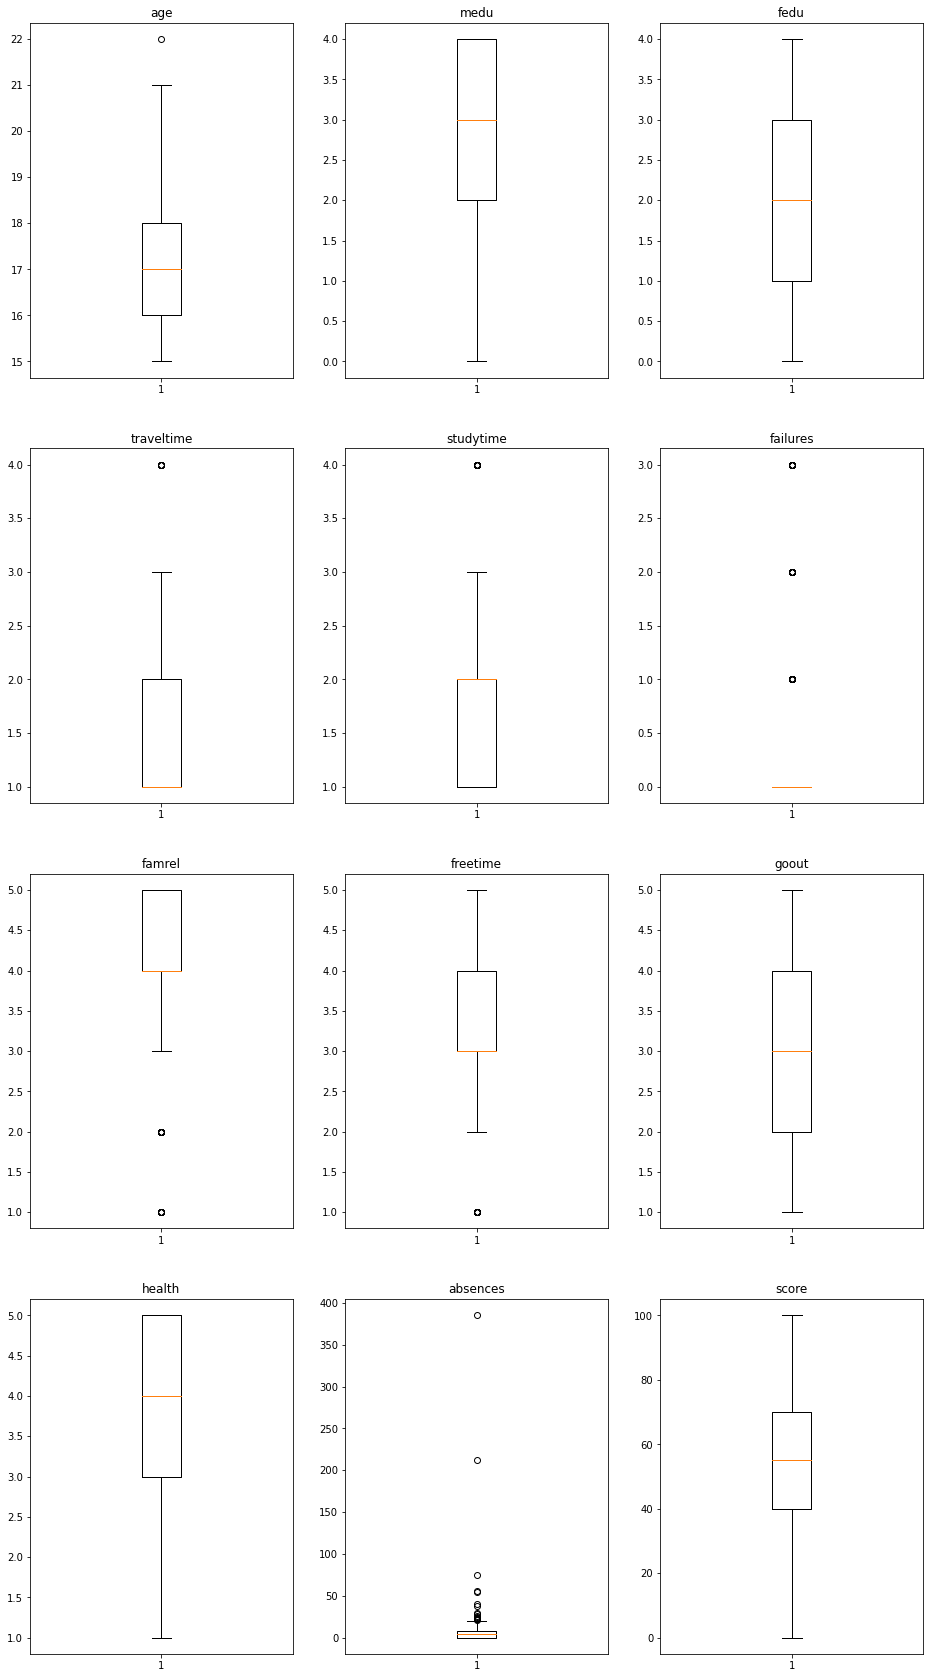

In [69]:
fig, axes = plt.subplots(4, 3, figsize=(16,30))

for i in range(len(numeric_df.columns)//3):
    for k in range(len(numeric_df.columns)//4):
        column = numeric_df.columns[k + (i * 3)]
        axes[i][k].set_title(column)
        axes[i][k].boxplot(numeric_df[~numeric_df[column].isna()][column])

Из диаграм видно что выбросы содержаться в колонках: **age, traveltime, studytime, failures, famrel, freetime, absences**

## age

Во время исследования данной колонки было замечано малое количество человек в возрастных группах: [20, 21, 22]. Удалим эти выбросы.

In [70]:
# Отберем возрастные группы в которых количество участников больше или равно 10 
df = filter_statistical_outliers('age', 10)

## traveltime

Учащихся далеко от дома меньше всего. Их всего 7. Пока не будем удалять их. 

## studytime

Учащихся более 4 часов 27 человек, это сильно меньше остальных, но не так уж и мало. Пока не будем удалять их.

## failures

Учащихся без неудач сильно больше чем тех, у кого было [1, 2, 3] неудачи. Но в этих группах все же не мало детей. Оставляем как есть.

## famrel

В этой колонке так же присутствует сдвиг, но количество детей в группах [1, 2] не мало. 8 и 17 детей соответственно. Оставляем пока как есть.

## freetime

В этой колонке так же присутствует сдвиг, но количество детей в группах [1] не мало. Оставляем пока как есть.

## absences

В этой колонке есть два значения сильно выделющиеся от остальных: [212, 385]. Уберем их.

In [71]:
df = df[df['absences'].isin([212, 385])]

# Оценить количество уникальных значений для номинативных переменных.

# По необходимости преобразовать данные.

# Провести корреляционный анализ количественных переменных.

# Отобрать не коррелирующие переменные.

# Проанализировать номинативные переменные и устраните те, которые не влияют на предсказываемую величину (`score`)

# Сформулировать выводы относительно качества данных и тех переменных, которые будут использоваться в дальнейшем построении модели.